In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [9]:
base_dir = '/nas/vhluong/Result/Orion_333/debug_GordonHCP/version_17'
version = 'version_17'
train_folder = os.path.join(base_dir, version, 'train_performance')
test_folder = os.path.join(base_dir, version, 'test_performance')
print(train_folder)
print(test_folder)

/nas/vhluong/Result/Orion_333/debug_GordonHCP/version_17/version_17/train_performance
/nas/vhluong/Result/Orion_333/debug_GordonHCP/version_17/version_17/test_performance


In [10]:
batch_num = 1
orig = np.load(test_folder + '/orig_batch_'+str(batch_num)+'.npy')[:, :200, :]
pred = np.load(test_folder+'/pred_batch_'+str(batch_num)+'.npy')[:, :200, :]
# mask = np.load(test_folder+'/mask_batch_'+str(batch_num)+'.npy')
print("Original:", orig.shape)
print("Prediction:", pred.shape)
# print("Mask:", mask.shape)

Original: (8, 200, 333)
Prediction: (8, 200, 333)


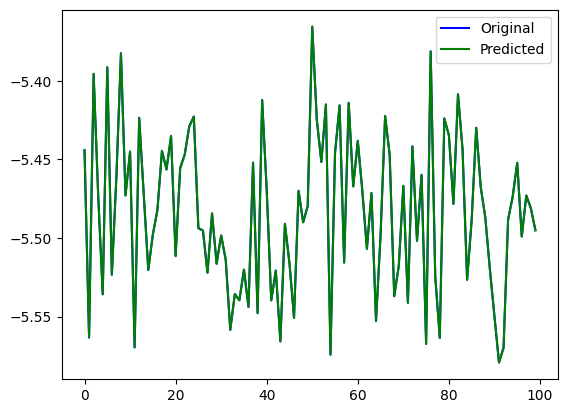

In [13]:
sample_num = 5
channel_num = 10
plt.plot(orig[sample_num, :100, channel_num], color='blue', label='Original')
plt.plot(pred[sample_num, :100, channel_num], color='green', label='Predicted')
plt.legend()
plt.show()

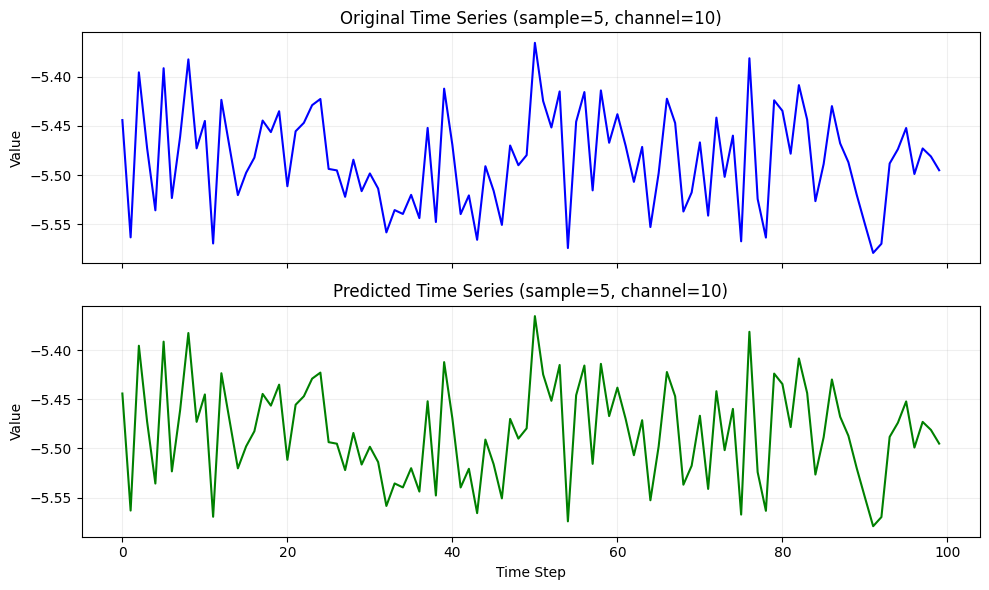

In [14]:
sample_num = 5
channel_num = 10
t = np.arange(100)

orig_series = orig[sample_num, :100, channel_num]
pred_series = pred[sample_num, :100, channel_num]

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

axes[0].plot(t, orig_series, color='blue')
axes[0].set_title(f'Original Time Series (sample={sample_num}, channel={channel_num})')
axes[0].set_ylabel('Value')
axes[0].grid(alpha=0.2)

axes[1].plot(t, pred_series, color='green')
axes[1].set_title(f'Predicted Time Series (sample={sample_num}, channel={channel_num})')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Value')
axes[1].grid(alpha=0.2)

plt.tight_layout()
plt.show()
